## Open 3-qubit chain "punched" by measurements

## Introduction

Here we use Qiskit 1.0 to simulate a chain of 3 qubits, where one of the qubits is subject to periodic measurements. More specifically, we choose a particular Hamiltonian to simulate the interactions between the qubits and calculate its expectation value right after each measurement. Hopefully this will help us to gain insight on how the energy of the system may be "disturbed" by ancillary measurement processes.

As this notebook is the very start of this investigation, it is worth to keep things simple. So we begin by simulating our system locally, reserving to run it directly on real quantum hardware for the future.

## Outline of the project

### Measurement protocol

If $H$ is the Hamiltonian of the system, our idea is to repeat the following steps several times:

1. Evolve the chain a time $\Delta t$.
2. Measure the rightmost qubit.
3. Compute $\langle H \rangle$.

It is useful to call a single implementation of these three instructions a __step__, and a sequence of $n$ integer steps a __trajectory__. Thus, the $i$-th trajectory is characterized by the set of $n$ expectation values $\{ \langle H \rangle^i_{\Delta t}, \langle H \rangle^i_{2 \Delta t}, ..., \langle H \rangle^i_{n \Delta t} \} \equiv \gamma^i_n$.

Two types of chains can be considered: __open chains__, where the two end-tip qubits don't interact, and __closed chains__, where they do.

Let us work initially with an open chain. We may choose

\begin{equation}
    \begin{split}
        H &= - \frac{J_1}{2} I \otimes X \otimes X - \frac{J_2}{2} Z \otimes Z \otimes I\\
    \end{split}
\end{equation}

where $J_1$, $J_2$ and $J_3$ are (coupling) constants. Our unitary time evolution operator at each step is then $U = exp\{ - i H \Delta t \}$.

We can define these two operators in qiskit like so:

In [41]:
from scipy.linalg import expm
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import UnitaryGate

## Parameters
J_1 = J_2 = 2.0 # Coupling constants
dt = 0.5 # Step interval

## Operators
H = SparsePauliOp(data = ["XXI", "IZZ"], coeffs = [-J_1/2, -J_2/2]) # Hamiltonian
U_dt = UnitaryGate(expm(-1.0j*H.to_matrix()*dt), label = r"$U_{\Delta t}$") # Time-evolution operator

### Quantum trajectories

Because of the random nature of measurements, it is clear that two distinct trajectories may differ drastically from each other. This suggests that, in order to obtain a general picture of our system, it is more relevant to consider _mean_ values instead of expectation values alone.

Moreover, if we submit the chain to a large number of trajectories, $N$, we can determine the probability that the trajectory $\gamma^i_n$ will occur: $p(\gamma^i_n) \equiv N^i/N$, where $N^i$ is the number of times that $\gamma^i_n$ occurs after the $N$ repetitions. Thus, it makes sense to write:
\begin{equation}
    \langle H \rangle_n = \sum_{i=1}^N p(\gamma^i_n) \langle H \rangle^i_{n \Delta t}.
\end{equation}
This formula accounts for both types of uncertainties: classical (associated to the probabilities $p(\gamma^i)$, which represent our ignorance about which specific trajectory will occur in a experiment) and quantum (associated with the probabilities of each measurement outcome, embedded within $\langle H \rangle^i_n$).

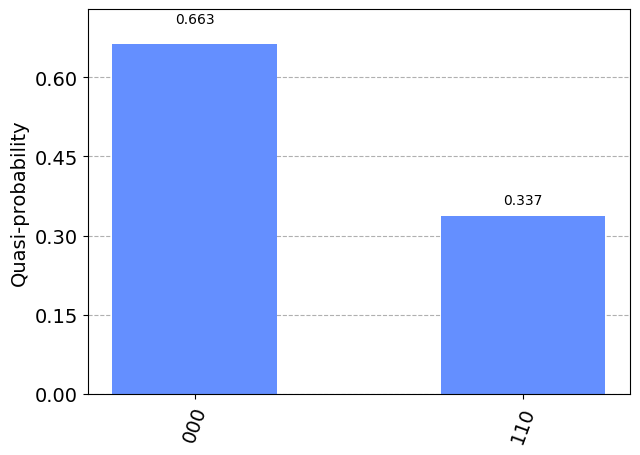

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution

## Trajectories

num_steps = 2 # Number of steps
expvals = np.zeros(num_steps) # Array to store expectation values
chain = QuantumCircuit(3, 1)

## Calling Sampler
for step in range(num_steps):
    chain.append(U_dt, [0, 1, 2])
    chain.measure(2, 0)

chain.measure_all()

backend = AerSimulator()
sampler = Sampler(backend = backend)
job = sampler.run([chain], shots = 10000)
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_distribution(counts)